### Download and load a previously trained model

Which was saved using:

```python
torch.save(model._neural_diffeq.state_dict(), "scdiffeq_model_checkpoint.pt")
```

In [1]:
import sys
sys.path.insert(0, '/Users/ruitong/scDiffEq')
from scDiffEq_simulation import *

device = "cpu"

rm: /Users/ruitong/.cache/matplotlib: No such file or directory
rm: -rf: No such file or directory
Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [2]:
if not exists("./scdiffeq_model_checkpoint.pt"):   
    ! gsutil -m cp -r gs://ruitong-rotation/scdiffeq_model_checkpoint.pt .

In [3]:
diffeq = neural_diffeq(in_dim=50,
                    out_dim=50,
                    mu={1: [800, 800], 2: [800, 800]},
                    sigma={1: [400, 400], 2: [400, 400]},)
diffeq.load_state_dict(torch.load("scdiffeq_model_checkpoint.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

### Set-up the simulation inputs

In [4]:
if not exists("./Weinreb2020.adata.h5ad"):   
    ! gsutil -m cp -r gs://ruitong-rotation/Weinreb2020.adata.h5ad .

In [5]:
h5adf = "Weinreb2020.adata.h5ad" if not exists("Weinreb2020_newpca.adata.h5ad") else "Weinreb2020_newpca.adata.h5ad"
adata = read_h5ad(h5adf)

In [6]:
if not exists("PCA_WholeLarry_scalar.pickle"):
    annRaw = read_h5ad("../ProcData/Weinreb2020_WholeRaw.adata.h5ad")
    Raw_hvg = annRaw.X[:,annRaw.var.index.isin(adata.var.index)].todense()
    scaler=sklearn.preprocessing.StandardScaler()
    x_ =scaler.fit_transform(Raw_hvg)
    pca = sklearn.decomposition.PCA(n_components = 50)
    adata.obsm['X_pca'] = pca.fit_transform(x_)
    pickle.dump(pca, file = open("PCA_WholeLarry_scalar.pickle", "wb"))
    adata.write("Weinreb2020_newpca.adata.h5ad")

In [7]:
if not exists("UMAP_WholeLarry_PCA.pickle"):
    umap_model = umap.UMAP(n_components=2)
    X_umap = umap_model.fit_transform(adata.obsm['X_pca'])
    pickle.dump(umap_model, file = open("UMAP_WholeLarry_PCA.pickle", "wb"))

In [8]:
# get some early cells
if not exists("toytest_2k.pickle"):
    d2 = adata.obs.loc[adata.obs['Time point'] == 2]
    idx = np.random.choice(d2.index, 2000)

In [9]:
idx = pickle.load(open("toytest_2k.pickle", "rb"))
pca_model = pickle.load(open("PCA_WholeLarry_scalar.pickle", "rb"))
umap_model = pickle.load(open("UMAP_WholeLarry_PCA.pickle", "rb"))

In [10]:
X0 = torch.Tensor(adata[idx].obsm['X_pca']).to(device)
t = torch.Tensor([0, 0.01, 0.02]).to(device)
diffeq = diffeq.to(device)

### Visualize predictions

Build a baseline/reference umap model:

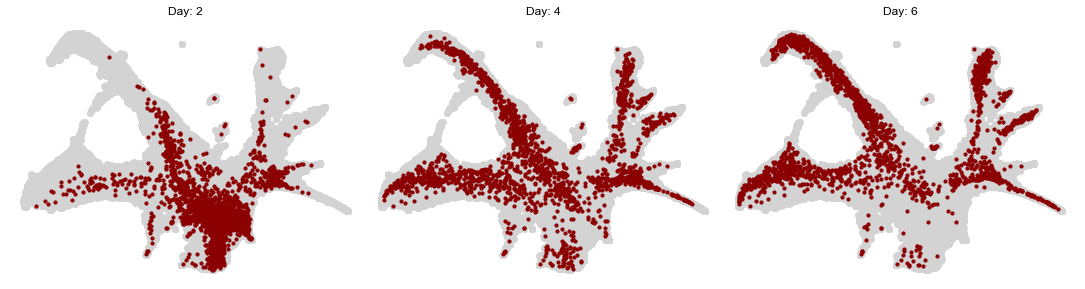

In [11]:
prog_umap(umap_model,adata,idx,diffeq,perturb=False,pcamodel= None,zs=None)

Running perturbations of Klf4;Nr4a1 w/ z-score of 5


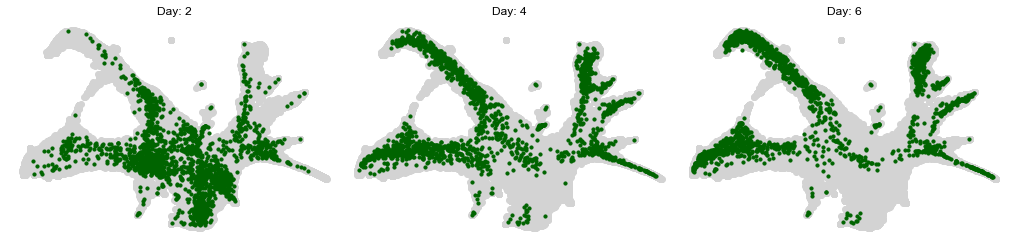

In [12]:
prog_umap(umap_model,adata,idx,diffeq,perturb=True,pcamodel= pca_model,zs=5)

Running perturbations of Klf4;Nr4a1 w/ z-score of -5


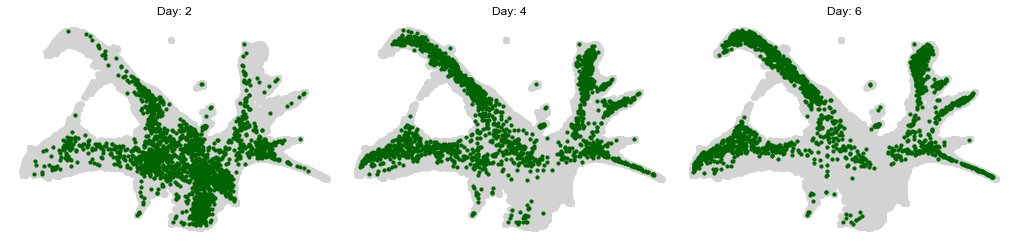

In [13]:
prog_umap(umap_model,adata,idx,diffeq,perturb=True,pcamodel= pca_model,zs=-5)

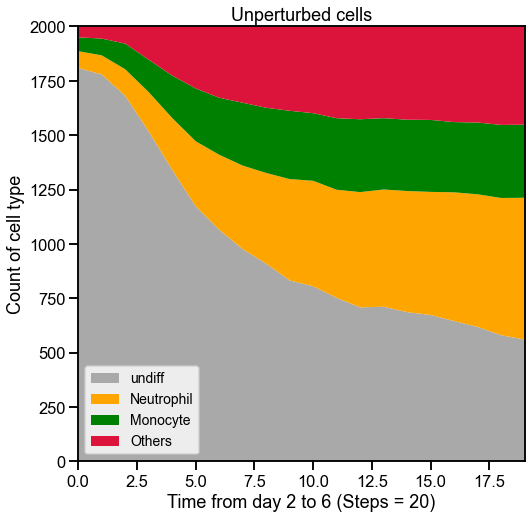

In [14]:
_ = continum_celltype(adata,idx,diffeq)

Running perturbations of Klf4;Nr4a1 w/ z-score of -5


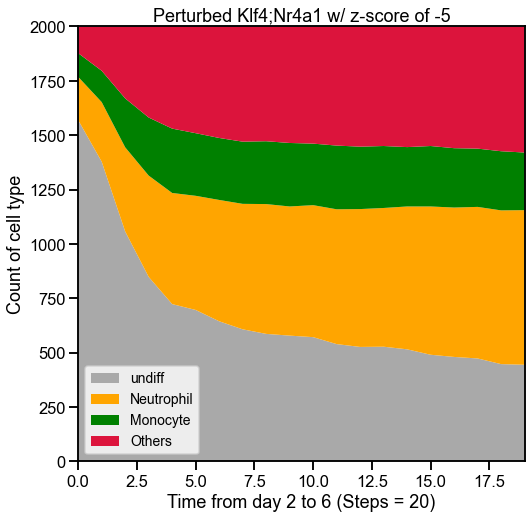

In [15]:
_ = continum_celltype(adata,idx,diffeq,perturb=True,
                      pcamodel= pca_model,zs=-5)

Running perturbations of Klf4;Nr4a1 w/ z-score of 20


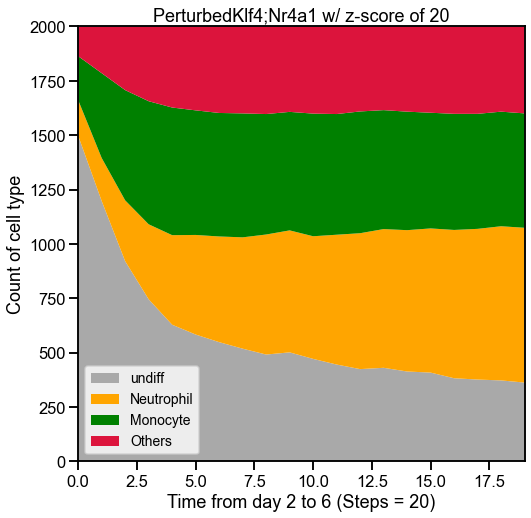

In [14]:
_ = continum_celltype(adata,idx,diffeq,perturb=True,
                      pcamodel= pca_model,zs=20)

Multiple header file got deprecated/messed up in newer mac os systems.

I have tried multiple methods:
+ Reomve and reinstall xcode-select (almost 30mins)
+ Try add symbolic link to /usr/include since that permanently got removed by mac
+ Add xcrun path to .bash_profile and also .zshrc
+ The original error of not locating stdio.h resolved with new errors
+ Ultimately, I think there are some incompatibilty of header location in the new mac sys


Decided to change to another method for finding approximate nearest neighbors.

Annoy's author [benchmarked](https://erikbern.com/2018/06/17/new-approximate-nearest-neighbor-benchmarks.html) multiple methods and sugggested to use [hnsw(nmbslib)](https://nmslib.github.io/nmslib/quickstart.html#installation) for approximate nearst neighbors.